In [1]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cpu


In [22]:
import ot
from geomloss import SamplesLoss

## Toy dataset

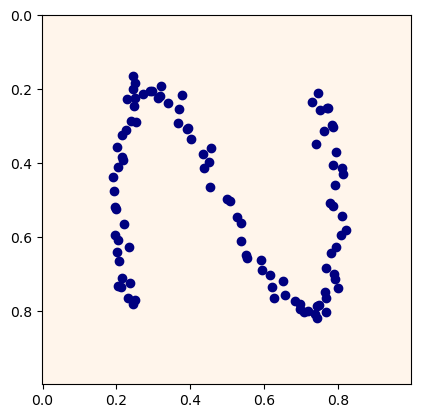

In [3]:
d = 2   # dimension of the data points

# # First dataset with 6 points
# n = 6
# y = torch.zeros((n,d), device=device)
# y[0, 0] = 0.9
# y[0, 1] = 0.2
# y[1, 0] = 0.75
# y[1, 1] = 0.8
# y[2, 0] = 0.3
# y[2, 1] = 0.4
# y[3, 0] = 0.4
# y[3, 1] = 0.7
# y[4, 0] = 0.45
# y[4, 1] = 0.75
# y[5, 0] = 0.7
# y[5, 1] = 0.5

# # make the points to be centered around [0,0]
# # get the mean
# mean = torch.mean(y, dim=0)
# y = y - mean

# Second dataset with 100 points, we use this for the rest of the
n = 100
t = torch.pi*torch.linspace(-.2,1.2,n)
y = .05*torch.randn((n,d))
y[:,0] += torch.cos(t)
y[:,1] += torch.sin(2*t)
y = .5 + .3*y
y = y.to(device)

# # make the points to be centered around [0,0]
# # get the mean
# mean_y = torch.mean(y, dim=0)
# y = y - mean_y

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device)/n

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
# plt.xticks([])
# plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Generator and Discriminator

In [18]:
class Generator(nn.Module):
    def __init__(self, n_z, n_hidden, n_out, device=torch.device('cpu')):
        super(Generator, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(n_z, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.fc4 = nn.Linear(n_hidden, n_out)

    def forward(self, z):
        h1 = F.elu(self.fc1(z))
        h2 = F.elu(self.fc2(h1))
        h3 = F.elu(self.fc3(h2))
        return torch.tanh(self.fc4(h3))
    
    

torch.Size([100, 2])


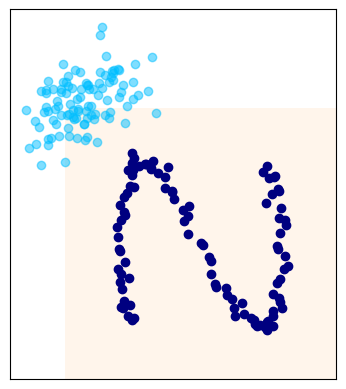

In [19]:
# plot initial config of the generator
# n_z = 10
# n_hidden = 100
# n_out = d
n_z=10 # should increase the dimension of the latent space; utile de sur paramétrer, 2 to 10
n_hidden=100 # big for 2d data; it is the most sensible
n_out=2

gen = Generator(n_z, n_hidden, n_out, device=device).to(device)

# generate a batch of noise
b = 100
z = torch.randn(b, n_z, device=device)

# use generator to generate x
x = gen(z)

print(x.shape)

# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

In [20]:
class Discriminator(nn.Module):
    def __init__(self, n_in, n_hidden, n_out, device=torch.device("cpu")):
        super(Discriminator, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(n_in, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.fc4 = nn.Linear(n_hidden, n_out)

    def forward(self, x):
        h1 = F.leaky_relu(self.fc1(x), 0.2)
        h2 = F.leaky_relu(self.fc2(h1), 0.2)
        h3 = F.leaky_relu(self.fc3(h2), 0.2)
        return torch.sigmoid(self.fc4(h3))

In [21]:
class Discriminator(nn.Module):
    def __init__(self, n_in, n_hidden, n_out, device=torch.device("cpu")):
        super(Discriminator, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(n_in, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.fc4 = nn.Linear(n_hidden, n_out)

    def forward(self, x):
        h1 = F.leaky_relu(self.fc1(x), 0.2)
        h2 = F.leaky_relu(self.fc2(h1), 0.2)
        h3 = F.leaky_relu(self.fc3(h2), 0.2)
        return torch.sigmoid(self.fc4(h3))

## MMD Loss

First code the linear kernel for the MMD loss, it is expressed in expression:

$$
k(x,y) = \langle x,y \rangle
$$

In [27]:
def linear_kernel(x, y):
    return torch.matmul(x, y.t())

In [28]:
# Test the linear kernel function
x = [[1, 2], [3, 4], [5, 6]]
y = [[1, 2], [3, 4]]

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

linear_kernel(y,y)

tensor([[ 5., 11.],
        [11., 25.]])

Code the MMD loss using the linear kernel. The MMD loss is defined as:

$$
\text{MMD}^2(p, q) = \left\| \frac{1}{n} \sum_{i=1}^n \varphi(x_i) - \frac{1}{m} \sum_{j=1}^m \varphi(y_j) \right\|^2

$$

where $\varphi$ is the feature map associated to the kernel $k$.

In [29]:
def compute_mmd_linear(x, y):
    m = x.size(0)
    n = y.size(0)
    
    # Calculate the kernel matrices
    K_xx = linear_kernel(x, x)
    K_yy = linear_kernel(y, y)
    K_xy = linear_kernel(x, y)
    
    # Zero diagonal elements (without in-place operation)
    K_xx = K_xx - torch.diag_embed(torch.diagonal(K_xx))
    K_yy = K_yy - torch.diag_embed(torch.diagonal(K_yy))
    
    # Compute the MMD using the unbiased estimator
    term1 = K_xx.sum() / (m * (m - 1))
    term2 = K_yy.sum() / (n * (n - 1))
    term3 = 2 * K_xy.sum() / (m * n)
    
    mmd = term1 + term2 - term3
    return F.relu(mmd)

Code the rbf kernel for MMD loss

In [30]:
# Function to calculate the RBF kernel matrix
def rbf_kernel(x, y, sigma):
    pairwise_distances = torch.cdist(x, y) ** 2
    return torch.exp(-pairwise_distances / (2 * sigma ** 2))

In [31]:
# Function to calculate the unbiased MMD
def compute_mmd_rbf(x, y, sigma=1.0):
    m = x.size(0)
    n = y.size(0)

    # Calculate the kernel matrices
    K_xx = rbf_kernel(x, x, sigma)
    K_yy = rbf_kernel(y, y, sigma)
    K_xy = rbf_kernel(x, y, sigma)

    # Zero diagonal elements (without in-place operation)
    K_xx = K_xx - torch.diag_embed(torch.diagonal(K_xx))
    K_yy = K_yy - torch.diag_embed(torch.diagonal(K_yy))

    # Compute the MMD using the unbiased estimator
    term1 = K_xx.sum() / (m * (m - 1))
    term2 = K_yy.sum() / (n * (n - 1))
    term3 = 2 * K_xy.sum() / (m * n)

    mmd = term1 + term2 - term3
    return F.relu(mmd)

We code RQ kernel

In [32]:
# Function to calculate the rational quadratic kernel matrix
def rational_quadratic_kernel(x, y, alpha=1.0):
    pairwise_distances = torch.cdist(x, y) ** 2
    return (1 + pairwise_distances / (2 * alpha)) ** -alpha

In [33]:
# Function to calculate the unbiased MMD with rational quadratic kernel
def compute_mmd_rational_quadratic(x, y, alpha=1.0):
    m = x.size(0)
    n = y.size(0)

    # Calculate the kernel matrices
    K_xx = rational_quadratic_kernel(x, x, alpha)
    K_yy = rational_quadratic_kernel(y, y, alpha)
    K_xy = rational_quadratic_kernel(x, y, alpha)

    # Zero diagonal elements (without in-place operation)
    K_xx = K_xx - torch.diag_embed(torch.diagonal(K_xx))
    K_yy = K_yy - torch.diag_embed(torch.diagonal(K_yy))

    # Compute the MMD using the unbiased estimator
    term1 = K_xx.sum() / (m * (m - 1))
    term2 = K_yy.sum() / (n * (n - 1))
    term3 = 2 * K_xy.sum() / (m * n)

    mmd = term1 + term2 - term3
    return F.relu(mmd)

We code a kernel related to Wasserstein distance

In [60]:
def pairwise_wasserstein_distances(x, y):
    # Assumes x and y are batches of distributions, each row a distribution
    # x and y should have shapes [batch_size, features]
    batch_size_x, _ = x.shape
    batch_size_y, _ = y.shape
    distances = torch.zeros((batch_size_x, batch_size_y), device=x.device)

    for i in range(batch_size_x):
        for j in range(batch_size_y):
            # Calculate the cost matrix between each pair of distributions
            cost_matrix = ot.dist(x[i].detach().cpu().numpy().reshape(-1, 1), 
                                  y[j].detach().cpu().numpy().reshape(-1, 1), 
                                  metric='euclidean')
            
            print(cost_matrix)
            # Calculate Wasserstein distance using POT
            distances[i, j] = ot.emd2([], [], cost_matrix)

    return distances


def wasserstein_kernel(x, y, lambda_param=1.0):
    # Compute pairwise Wasserstein distances
    pairwise_distances = pairwise_wasserstein_distances(x, y)
    # Apply the exponential kernel function
    return torch.exp(-lambda_param * pairwise_distances)


In [56]:
# Test the Wasserstein distance function
wasserstein_kernel(x, x)

tensor([[1.0000, 0.1353, 0.0183],
        [0.1353, 1.0000, 0.1353],
        [0.0183, 0.1353, 1.0000]])

In [57]:
def compute_mmd_wasserstein(x, y, lambda_param=1.0):
    m = x.size(0)
    n = y.size(0)

    # Calculate the kernel matrices
    K_xx = wasserstein_kernel(x, x, lambda_param)
    K_yy = wasserstein_kernel(y, y, lambda_param)
    K_xy = wasserstein_kernel(x, y, lambda_param)

    # Zero diagonal elements (without in-place operation)
    K_xx = K_xx - torch.diag_embed(torch.diagonal(K_xx))
    K_yy = K_yy - torch.diag_embed(torch.diagonal(K_yy))
    
    # print(K_xx.shape, K_yy.shape, K_xy.shape)

    # Compute the MMD using the unbiased estimator
    term1 = K_xx.sum() / (m * (m - 1))
    term2 = K_yy.sum() / (n * (n - 1))
    term3 = 2 * K_xy.sum() / (m * n)

    mmd = term1 + term2 - term3
    # return torch.relu(mmd)
    
    return mmd

In [58]:
# Test the MMD loss with Wasserstein kernel
compute_mmd_wasserstein(x, y)

tensor(-0.5764)

## Only train the generator

Using wasserstein kernel

In [59]:
n_z = 10
n_hidden = 100
n_out = d

b=100

gen = Generator(n_z, n_hidden, n_out, device=device).to(device)

# Optimizer
optimizer_g = optim.Adam(gen.parameters(), lr=1e-3) # different lr with different local minima;

# Training loop
num_epochs = 200
batch_size = 100
losses_g = []

dots = []

for epoch in range(num_epochs):
    real_data = y.to(device)
    # print("real_data", real_data.shape)
    z = torch.randn(b, n_z, device=device)
    fake_data = gen(z)
    
    optimizer_g.zero_grad()
    mmd = compute_mmd_wasserstein(real_data, fake_data)
    # mmd = compute_mmd_rbf(real_data, fake_data)
    loss_g = mmd
    
    loss_g.backward()
    optimizer_g.step()
    
    losses_g.append(loss_g.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss G: {loss_g.item():.4f}')
        
    # save the dots in each epochs so that we can finally plot the changes in each epoch
    dots.append(fake_data)
    

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator')
plt.legend()
plt.title('Generator Loss')

# plot the generated dots as gif
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
for i in range(len(dots)):
    # use detach
    
    dots_detached = dots[i].detach()
    plt.scatter(dots_detached[:, 0].cpu(), dots_detached[:,1].cpu(),c='deepskyblue',alpha=.5)
    plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
    plt.savefig(f'./images_wasserstein/epoch_{i}.png')
    plt.clf()
    
    

plt.figure(figsize=(10, 5))
plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='blue', label='Real data')
with torch.no_grad():
    z = torch.randn(n, 2).to(device)
    fake_data = gen(z).cpu()
    plt.scatter(fake_data[:, 0], fake_data[:, 1], c='red', label='Generated data')
plt.legend()
plt.title('Generated Data vs Real Data')
plt.show()


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.